In [6]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import utils, build_features_final
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()


def add_motor_hp(df):
    """
    설비 번호에 따라 모터의 마력을 계산하여 feature로 추가합니다.

    Args:
        df (pandas.DataFrame): 모터 마력을 추가할 데이터프레임

    Returns:
        pandas.DataFrame: 모터 마력이 추가된 데이터프레임
    """
    df["motor_hp"] = 0
    df.loc[df["type"].isin([0, 4, 5, 6, 7]), "motor_hp"] = 30
    df.loc[df["type"] == 1, "motor_hp"] = 20
    df.loc[df["type"] == 2, "motor_hp"] = 10
    df.loc[df["type"] == 3, "motor_hp"] = 50
    return df


train_data = pd.read_csv('juu_train.csv')
train_data = add_motor_hp(train_data)

test_data = pd.read_csv('juu_test.csv')
test_data = add_motor_hp(test_data)

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

scaled_train_data_df = scaled_train_data.copy()
scaled_test_data_df = scaled_test_data.copy()

grouped_train = scaled_train_data.groupby('motor_hp')

drop_feature = ['type', 'motor_hp']

anomaly = []
all_threshold = []
for group_name, group_data in grouped_train:
    test_group = scaled_test_data[scaled_test_data['motor_hp'] == group_name]
    train_group = group_data.drop(drop_feature, axis=1).values
    test_group = test_group.drop(drop_feature, axis=1).values

    n_features = train_group.shape[1]
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    model = predict_model.AutoEncoder(input_dim=n_features, latent_dim=256)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    train_prediction, train_threshold = evaluation(train_loader, model)
    test_prediction, test_threshold = evaluation(
        test_loader, model, min(train_threshold))

    anomaly.append(test_prediction)
    all_threshold.append(test_threshold)
    print(f"finish {group_name}type")

all_threshold = np.concatenate(all_threshold)
anomaly = np.concatenate(anomaly)
submission = prediction_to_csv(anomaly)


Epoch [0/500], Loss: 0.3573069
Epoch [100/500], Loss: 0.0179377
Epoch [200/500], Loss: 0.0022197
Epoch [300/500], Loss: 0.0018914
Epoch [400/500], Loss: 0.0018018
finish 0.0type
Epoch [0/500], Loss: 0.2878337
Epoch [100/500], Loss: 0.0212519
Epoch [200/500], Loss: 0.0037729
Epoch [300/500], Loss: 0.0021536
Epoch [400/500], Loss: 0.0020414
finish 0.25type
Epoch [0/500], Loss: 0.3181903
Epoch [100/500], Loss: 0.0090030
Epoch [200/500], Loss: 0.0040889
Epoch [300/500], Loss: 0.0036762
Epoch [400/500], Loss: 0.0027038
finish 0.5type
Epoch [0/500], Loss: 0.3722743
Epoch [100/500], Loss: 0.0405916
Epoch [200/500], Loss: 0.0029961
Epoch [300/500], Loss: 0.0022192
Epoch [400/500], Loss: 0.0019963
finish 1.0type
label
0    7011
1     378
Name: count, dtype: int64


In [7]:
test_data['label'] = anomaly
test_data['treshold'] = all_threshold
def no_out(test_data):
    test7342 = test_data[7342:7361]
    
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no
yes, no = no_out(test_data)

Chunk 0: 31/1296 labels with value 1


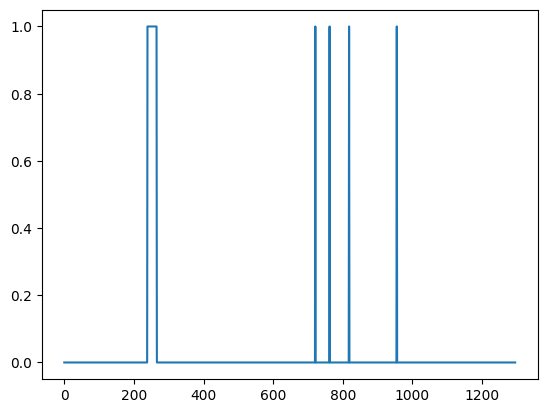

Chunk 1: 0/1107 labels with value 1


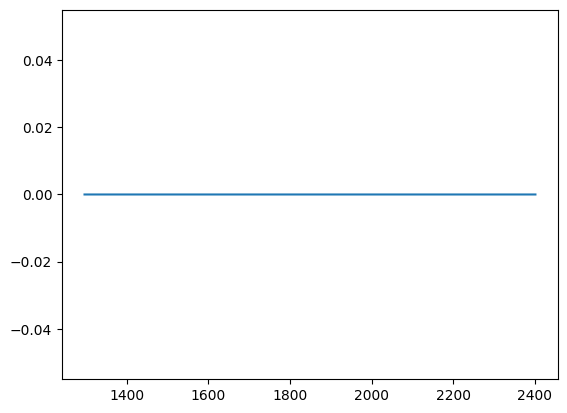

Chunk 2: 143/1098 labels with value 1


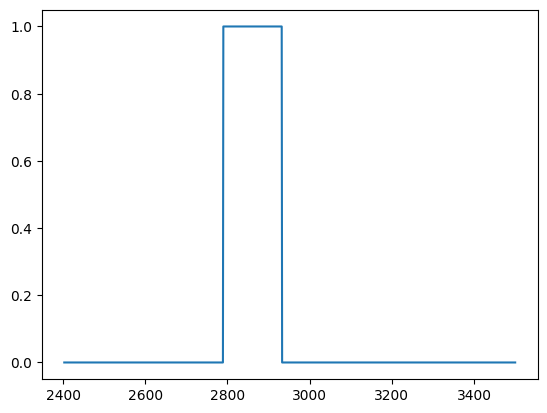

Chunk 3: 17/918 labels with value 1


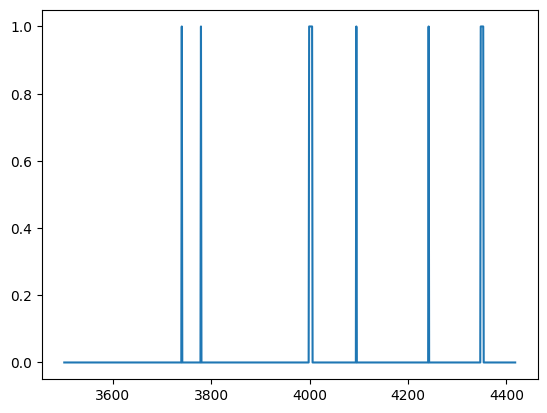

Chunk 4: 30/918 labels with value 1


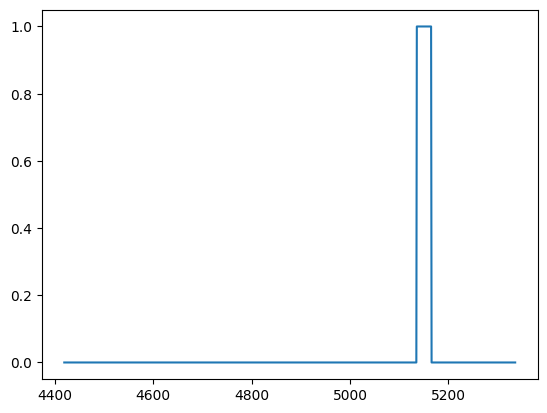

Chunk 5: 101/746 labels with value 1


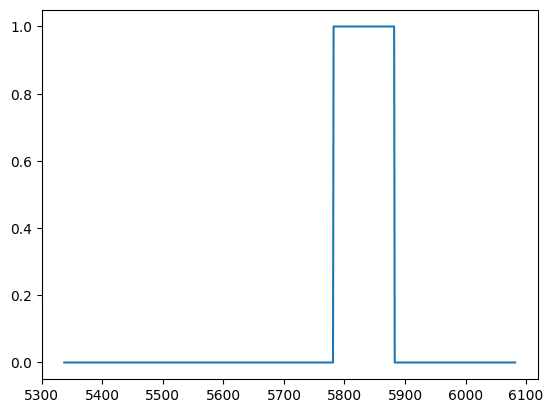

Chunk 6: 11/748 labels with value 1


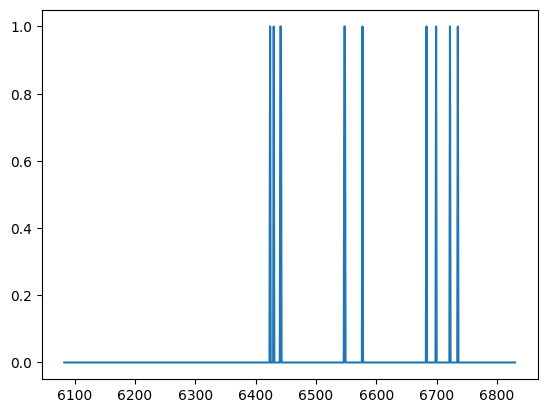

Chunk 7: 45/558 labels with value 1


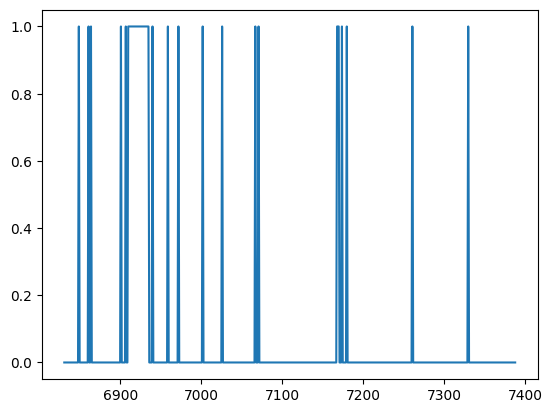

In [8]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels}/{len(chunk)} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(anomaly))]
plot_label_counts(submission, ranges)